# **SVHN Classification using PyTorch Image Models**
In this notebook, we train three models on The Street View House Numbers (SVHN) Dataset using  PyTorch Image Models (timm) module. 

_Brief Description and Overview of the SVHN Dataset_

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data preprocessing and formatting. It can be seen as similar in flavor to MNIST (e.g., the images are of small cropped digits), but incorporates an order of magnitude more labeled data (over 600,000 digit images) and comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

Overview:

*  10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
* 73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data
* Comes in two formats:
  1. Original images with character level bounding boxes.
  2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

(Source: http://ufldl.stanford.edu/housenumbers)

In [65]:
# Load the necessary libraries
!pip install timm
import timm
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

**Load the SVHN dataset using torchvision**

Note: In this dataset, '0' has a label 0 instead of 10

In [ ]:
# Download our datasets and apply transforms using the torchvision module
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])
data_transform = {'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/SVHN'
image_datasets = {x: datasets.SVHN(os.path.join(data_dir, x), split = x, transform = data_transform[x], download = True)
              for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 128,
                                             shuffle = True, num_workers = 0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print("Train dataset:", dataset_sizes['train'])
print("Test dataset:", dataset_sizes['test'])

class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Configure device to use GPU when available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Visualize sample images from the datasets**

In [ ]:
def imshow(input, title, label = ''):
    input = input.numpy().transpose((1, 2, 0))
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title.upper())
    plt.xlabel(label)
    plt.show()

num_samples = 5 # number of sample images to show
for x in ['train', 'test']:  
  # Get samples of data
  inputs, classes = next(iter(dataloaders[x]))
  # Make a grid using a number of samples (num_samples) from batch 
  out = torchvision.utils.make_grid(inputs[:num_samples], nrow  = num_samples)
  imshow(out, title = x, label = [class_names[name] for name in classes[:num_samples]])

**Train the model**

In this section, we write a function to train the model, track statistics and save the best model.

In [81]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_hist = []
    validation_hist = []
    time_hist = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs), end = " | ")
        epoch_start_time = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase.capitalize(), epoch_loss, epoch_acc), end = " | ")
            
            if phase == 'train':
                scheduler.step()
                train_hist.append([epoch_loss, epoch_acc])
            # deep copy the model
            else:
                validation_hist.append([epoch_loss, epoch_acc])
                if epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_weights = copy.deepcopy(model.state_dict())    
        time_hist.append(time.time() - epoch_start_time)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_weights)
    return model, train_hist, validation_hist, time_hist

**Model 1:  Resnet-18**

In this section, we load a pretrained ResNet-18 model, train and evaluate it.

Number of features:  512
Epoch 1/5 | Train Loss: 1.4102 Acc: 0.5172 | Test Loss: 0.8151 Acc: 0.7329 | 
Epoch 2/5 | Train Loss: 0.7439 Acc: 0.7542 | Test Loss: 0.5477 Acc: 0.8277 | 
Epoch 3/5 | Train Loss: 0.5584 Acc: 0.8187 | Test Loss: 0.4455 Acc: 0.8622 | 
Epoch 4/5 | Train Loss: 0.4631 Acc: 0.8518 | Test Loss: 0.3968 Acc: 0.8765 | 
Epoch 5/5 | Train Loss: 0.4058 Acc: 0.8728 | Test Loss: 0.3714 Acc: 0.8842 | 
Training complete in 5m 11s
Best Validation Accuracy: 0.884181


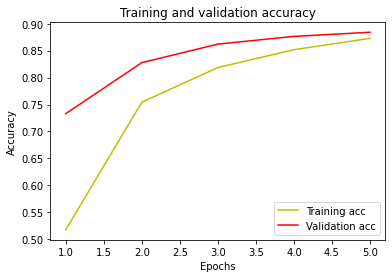

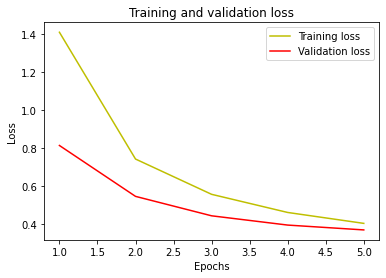

In [82]:
# Load a pretrained model and reset final fully connected layer.
model = timm.create_model('resnet18', pretrained = True)
num_ftrs = model.fc.in_features
print("Number of features: ", num_ftrs)

# Here the size of each output sample is set to 10.
num_output = 10
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(classes)).
model.fc = nn.Linear(num_ftrs, num_output)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

epochs = 5
model, train_hist, validation_hist, time_hist = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs = epochs)

plt.plot(range(1, epochs + 1), np.array(train_hist)[:, 1], color = 'y', label = 'Training acc')
plt.plot(range(1, epochs + 1), np.array(validation_hist)[:, 1], color = 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(range(1, epochs + 1), np.array(train_hist)[:, 0], color = 'y', label = 'Training loss')
plt.plot(range(1, epochs + 1), np.array(validation_hist)[:, 0], color = 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()